In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install tqdm
#!pip install scikit-learn

In [2]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 量子カーネル法を使ってみる

この notebook では、量子カーネル法による学習を qulacs によるシミュレーションで検証します。

## IBM から提案されたカーネル
ここでは量子カーネル法のさきがけである [Supervised learning with quantum-enhanced feature spaces](https://www.nature.com/articles/s41586-019-0980-2) という論文で提案された量子カーネルによる機械学習をしてみます。この論文では、古典→量子への特徴量写像として、以下の回路が提案されました。

In [3]:
def get_ibm_circuit(n_qubits):
    circuit = ParametricQuantumCircuit(n_qubits)
    for _ in range(2):
        for i in range(n_qubits):
            circuit.add_H_gate(i)    
        # these RZ gates will become RZ(x[i])
        for i in range(n_qubits):
            circuit.add_parametric_RZ_gate(i,0)
        # these RZZ gates will become RZZ_{ij}(-(x[i]-np.pi)*(x[j]-np.pi)))
        # we assume (open-boundary) one dimensional connection
        # note that experimentally, this layer can be executed in depth 2
        for i in range(n_qubits-1):
            circuit.add_parametric_multi_Pauli_rotation_gate([i,(i+1)%n_qubits],[3,3],0)
    return circuit

In [4]:
def set_input_to_ibm_circuit(x, ibm_circuit):
    now_index = 0
    for _ in range(2):
        # set first layer RZ parameters
        for i in range(now_index, now_index+n_qubits):
            ibm_circuit.set_parameter(i, x[(i-now_index)%len(x)])
        now_index += n_qubits
        # set first layer RZZ parameters
        for i in range(now_index, now_index+n_qubits-1):
            ibm_circuit.set_parameter(i, (np.pi-x[(i-now_index)%len(x)])*(np.pi-x[(i-now_index+1)%len(x)]))
        now_index += n_qubits-1

以下のコードで、2量子ビットの場合について、どのような特徴量写像となっているか見てみます。

In [5]:
# 諸々のパラメータ設定
n_qubits = 2
ibm_circuit = get_ibm_circuit(n_qubits)
x0 = np.linspace(0, 2*np.pi, 50)
x1 = np.linspace(0, 2*np.pi, 50)
x0, x1 = np.meshgrid(x0, x1)
state = QuantumState(n_qubits)
feature_vector = [np.zeros_like(x0, dtype=complex) for i in range(4)]
# grid の各点で特徴量ベクトルの成分を計算し、保存する。
for i in range(50):
    for j in range(50):
        state.set_zero_state()
        set_input_to_ibm_circuit([x0[i,j],x1[i,j]], ibm_circuit)
        ibm_circuit.update_quantum_state(state)
        vec = state.get_vector()
        for k, c in enumerate(vec):
            feature_vector[k][i,j] = vec[k]

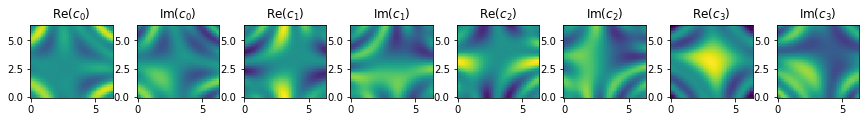

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(12,1.8))
for i in range(4):
    ax = fig.add_subplot(1,8,2*i+1)
    ax.pcolor(x0, x1, feature_vector[i].real, shading="nearest", vmin=-1, vmax=1)
    ax.set_title(f"Re($c_{i}$)")
    ax = fig.add_subplot(1,8,2*i+2)
    ax.pcolor(x0, x1, feature_vector[i].imag, shading="nearest", vmin=-1, vmax=1)
    ax.set_title(f"Im($c_{i}$)")
plt.tight_layout()
plt.show()

どんなデータセットに使えるのかはわかりませんが、こんな特徴量写像になっているようです。**ただここで一つ問題があります。** それは特徴ベクトルが複素数になっていることです。カーネル法は
$$\hat{y}(x)=\sum_a w_a\phi_a(x)$$
のようなモデルを作る手法なので、特徴量写像 $\phi(x)$ が複素数だと一般に複素数の予測値が出力されてしまいます。少しややこしいですね。この notebook では簡単なデモンストレーションを目的にしているので、ここでは上記の回路を少し変更して、波動関数に実数しか現れない以下のような量子回路を使うことにします。

※ IBM の論文では、量子状態 $|\psi(x)\rangle=U(x)|0\rangle$ ではなく、対応する密度行列 $\rho(x) = |\psi(x)\rangle\langle\psi(x)|$ を特徴量とみなすことによって、複素数の予測値が出る問題を回避できています。密度行列は実数ベクトルと考えられるためです。

以下のような実数しか現れない回路を定義します。$\exp(i\theta Y)$, $\exp(i\theta X\otimes Y)$, $\exp(i\theta Y\otimes X)$ という実数ゲートを使います。

In [7]:
def get_circuit(n_qubits):
    circuit = ParametricQuantumCircuit(n_qubits)
    for _ in range(2):
        # these RY gates will become RY(x[i])
        for i in range(n_qubits):
            circuit.add_parametric_RY_gate(i,0)
        # these RXY gates will become RXY_{ij}(-(x[i]-np.pi)*(x[j]-np.pi)))
        # we assume (open-boundary) one dimensional connection
        # note that experimentally, this layer can be executed in depth 2
        for i in range(n_qubits-1):
            circuit.add_parametric_multi_Pauli_rotation_gate([i,(i+1)%n_qubits],[1,2],0)
            circuit.add_parametric_multi_Pauli_rotation_gate([i,(i+1)%n_qubits],[2,1],0)
    return circuit

In [8]:
def set_input_to_circuit(x, circuit):
    now_index = 0
    for _ in range(2):
        # set layer RY parameters
        for i in range(now_index, now_index+n_qubits):
            circuit.set_parameter(i, x[(i-now_index)%len(x)])
        now_index += n_qubits
        # set layer RXY, RYX parameters
        for i in range(n_qubits-1):
            circuit.set_parameter(2*i+now_index, (np.pi-x[(i-now_index)%len(x)])*(np.pi-x[(i-now_index+1)%len(x)]))
            circuit.set_parameter(2*i+now_index+1, (np.pi-x[(i-now_index)%len(x)])*(np.pi-x[(i-now_index+1)%len(x)]))
        now_index += 2*(n_qubits-1)

同様に、2量子ビットの場合について、どのような特徴量写像となっているか見てみます。

In [9]:
# 諸々のパラメータ設定
n_qubits = 2
circuit = get_circuit(n_qubits)
x0 = np.linspace(0, 2*np.pi, 50)
x1 = np.linspace(0, 2*np.pi, 50)
x0, x1 = np.meshgrid(x0, x1)
state = QuantumState(n_qubits)
feature_vector = [np.zeros_like(x0, dtype=complex) for i in range(4)]
# grid の各点で特徴量ベクトルの成分を計算し、保存する。
for i in range(50):
    for j in range(50):
        state.set_zero_state()
        set_input_to_circuit([x0[i,j],x1[i,j]], circuit)
        circuit.update_quantum_state(state)
        vec = state.get_vector()
        for k, c in enumerate(vec):
            feature_vector[k][i,j] = vec[k]

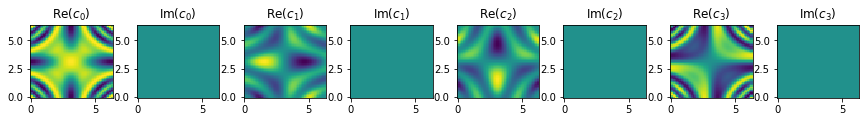

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(12,1.8))
for i in range(4):
    ax = fig.add_subplot(1,8,2*i+1)
    ax.pcolor(x0, x1, feature_vector[i].real, shading="nearest", vmin=-1, vmax=1)
    ax.set_title(f"Re($c_{i}$)")
    ax = fig.add_subplot(1,8,2*i+2)
    ax.pcolor(x0, x1, feature_vector[i].imag, shading="nearest", vmin=-1, vmax=1)
    ax.set_title(f"Im($c_{i}$)")
plt.tight_layout()
plt.show()

これもどんなデータに使えるかは良くわかりませんが、ともかく実数だけの特徴ベクトルへマップすることができました。

## カーネル法の準備

上記の量子回路による特徴量写像に対応するカーネル $k(x_i, x_j)$ を計算するための関数を準備しておきます。

In [11]:
# qulacs で内積を計算する関数
from qulacs.state import inner_product
# 毎回メモリ確保すると遅いので、カーネルの計算用に量子状態・量子回路を準備しておく。
n_qubits = 2
_circuit = get_circuit(n_qubits)
_state1 = QuantumState(n_qubits)
_state2 = QuantumState(n_qubits)
# 関数本体
def get_kernel_value(x1, x2):
    _state1.set_zero_state() #初期化
    set_input_to_circuit(x1, _circuit)
    _circuit.update_quantum_state(_state1) #x1に対応する状態を準備
    _state2.set_zero_state() #初期化
    set_input_to_circuit(x2, _circuit)
    _circuit.update_quantum_state(_state2) #x2に対応する状態を準備
    return inner_product(_state1, _state2)

カーネルを可視化してみます。$x_j$ を fix して、$|k(x_i,x_j)|$ の値を見てみます。

In [12]:
xj_list = [
    [0.,0.],
    [np.pi, np.pi],
    [np.pi/3, -np.pi/2.],
    [-np.pi/3, np.pi/6.] 
]
x0 = np.linspace(-2*np.pi, 2*np.pi, 100)
x1 = np.linspace(-2*np.pi, 2*np.pi, 100)
x0, x1 = np.meshgrid(x0, x1)

# grid の各点で特徴量ベクトルの成分を計算し、保存する。
kernel_values = [np.zeros_like(x0, dtype=complex) for i in range(len(xj_list))]
for index, xj in enumerate(xj_list):
    for i in range(100):
        for j in range(100):
            xi = [x0[i,j],x1[i,j]]
            kernel_values[index][i,j] = get_kernel_value(xi, xj)

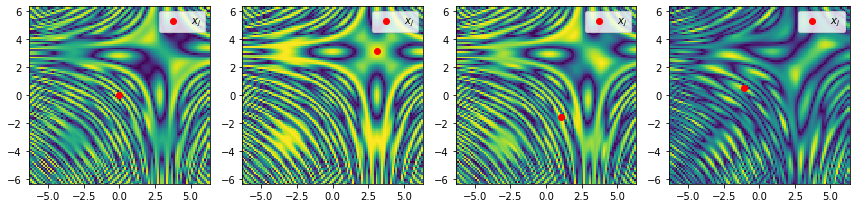

In [13]:
fig = plt.figure(figsize=(3*len(xj_list),3))
for i in range(len(xj_list)):
    ax = fig.add_subplot(1,len(xj_list),i+1)
    ax.pcolor(x0, x1, np.abs(kernel_values[i]), shading="nearest", vmin=0, vmax=1)
    ax.scatter(xj_list[i][0], xj_list[i][1], color="red", label="$x_j$")
    ax.legend()
plt.tight_layout()
plt.show()

カーネルの値が大きい場所は、特徴量空間での内積が大きい点に対応しており、このカーネル関数によって「$x_j$ と似ている」と判断される場所を示しています。$x_i=x_j$ のときはもちろん $k(x_i,x_j)=1$ ですが、このカーネルではかなり遠く離れた点同士も、ある一定の周期で「似ている」と判断されることが分かりました。かなり変なカーネルです。

## 簡単な回帰問題を解く

最初に簡単な回帰を行ってみます。目的のデータセットとして、2次元の入力データ $x=(x_0, x_1)$ から計算される簡単な関数を準備します。ここでは回帰がうまくいくように、上の特徴量写像で必ず表すことのできるデータとして、$|\psi(x)\rangle$ の $|01\rangle$ 振幅を訓練データとして利用します。適当に $x=(x_0, x_1)$ をサンプルし、対応する $|01\rangle$ 振幅を教師データとして準備します。

In [14]:
%matplotlib notebook
state = QuantumState(n_qubits)
circuit = get_circuit(n_qubits)
def get_output_vector(x):
    state.set_zero_state()
    set_input_to_circuit(x, circuit)
    circuit.update_quantum_state(state)
    return state.get_vector()

n_data = 100
n_grid = 100
X = np.random.rand(n_data, 2)*2*np.pi
y = np.array([get_output_vector(x)[0].real for x in X])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y)
x0_surface, x1_surface = np.meshgrid(np.linspace(0, np.pi*2, n_grid), np.linspace(0, np.pi*2, n_grid))
y_surface = np.zeros_like(x0_surface)
for i in range(n_grid):
    for j in range(n_grid):
        y_surface[i,j] = get_output_vector([x0_surface[i,j],x1_surface[i,j]])[0].real
ax.plot_surface(x0_surface, x1_surface, y_surface, cmap="summer", alpha=0.6)
ax.view_init(elev=45, azim=-77)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$y$")
plt.title("Traning dataset")
plt.show()

<IPython.core.display.Javascript object>

### カーネル行列を計算する
生成したデータ点に対してグラム行列 $G_{ij}=k(x_i, x_j)$を計算します。

In [15]:
# 対角成分はすべて 1 なので最初から 1 で埋めておく。
gram_matrix = np.identity(n_data, dtype=complex)
# 対称性を使って計算
for i in range(n_data):
    for j in range(i):
        gram_matrix[i,j] = get_kernel_value(X[i], X[j])
        gram_matrix[j,i] = gram_matrix[i,j].conjugate()

### カーネルリッジ回帰
カーネルリッジ回帰では、未知のデータ $\boldsymbol{x}$ に対する予測値 $\hat{y}$ を 
$$\boldsymbol{a}=(G+\lambda I)^{-1}\boldsymbol{y}$$ 
を使って 
$$\hat{y} = \sum_{i=1}^{N_{\mathrm{data}}} a_i k(\boldsymbol{x}_i, \boldsymbol{x})$$ 
によって計算します。以下の `predict` 関数がその実装です。

In [16]:
regularization = 0.000001
a = np.linalg.inv(gram_matrix + regularization*np.identity(n_data)).dot(y)
def predict(x):
    k_vector = np.array([get_kernel_value(x_train, x) for x_train in X], dtype=complex)
    return np.conj(a).dot(k_vector)

`predict` 関数がどのような曲面を描くか見てみましょう。少し時間がかかります。早く表示させたいときは `n_grid` を小さくしてください。

In [17]:
%matplotlib notebook
predict_surface = np.zeros_like(x1_surface, dtype=complex)
for i in range(n_grid):
    for j in range(n_grid):
        predict_surface[i,j] = predict([x0_surface[i,j],x1_surface[i,j]])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.scatter(X[:,0], X[:,1], y)
ax.plot_surface(x0_surface, x1_surface, predict_surface.real, cmap="summer", alpha=0.7)
ax.view_init(elev=45, azim=-77)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$y$")

ax = fig.add_subplot(122, projection='3d')
ax.set_title("True")
ax.scatter(X[:,0], X[:,1], y)
ax.plot_surface(x0_surface, x1_surface, y_surface, cmap="summer", alpha=0.7)
ax.view_init(elev=45, azim=-77)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$y$")

plt.show()

<IPython.core.display.Javascript object>

(理論的に当たり前ではありますが) 完璧にフィットできていることがわかります。 

## 分類問題を解く

### デモンストレーション用のデータセットを分類する。
次に適当なデータセットを scikit-learn で生成して、学習を行ってみましょう。ここでは `moon` データセットを生成します。これらのデータは上でやった回帰問題と違って、特徴量写像とはなんら関係無いデータセットなので、うまく分類できるかは微妙です。

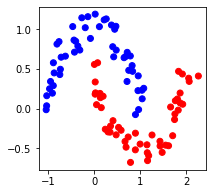

In [18]:
%matplotlib inline
from sklearn.datasets import make_circles, make_moons
n_data = 100
X_moon, Y_moon = make_moons(n_data, noise=0.1)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.scatter(X_moon[:,0], X_moon[:,1], c=Y_moon, cmap="bwr")
plt.show()

入力 X の取りうる範囲を調整したほうがいいような気もしますが、とりあえず何も考えずに kernel support vector machine (カーネルSVM) に突っ込みます。回帰と違ってカーネル SVM を自前で実装するのは少し面倒なので、scikit-learn に入っている SVM を使います。ドキュメンテーションは[ここ。](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [19]:
from sklearn.svm import SVC

scikit-learn の SVM にはユーザーが作ったカーネルによってカーネル SVM を実行してくれるオプションがあります。これを使うためには、 [ドキュメントにあるように](https://scikit-learn.org/stable/modules/svm.html#custom-kernels)、`(n_samples_1, n_features)`, `(n_samples_2, n_features)` の入力データの入った 2 つの numpy array を受け取って、`(n_samples_1, n_samples_2)` のグラム行列を返す関数を作る必要があります。以下がその関数です。

In [20]:
def get_gram_matrix(X1, X2):
    gram_matrix = np.zeros((len(X1), len(X2)))
    for i1, x1 in enumerate(X1):
        for i2, x2 in enumerate(X2):
            gram_matrix[i1,i2] = get_kernel_value(x1, x2).real
    return gram_matrix

作ったグラム行列計算関数を使って、SVM を構成し、学習します。

In [21]:
regularization = 1.0 # smaller values lead to stronger regularization
svc = SVC(C=regularization, kernel=get_gram_matrix)
svc.fit(X_moon, Y_moon)

SVC(kernel=<function get_gram_matrix at 0x7f646a7a2af0>)

どのように学習されているか見てみます。背景が分離平面からの距離を表します。少し計算時間が掛かります。

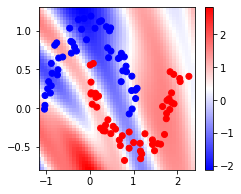

In [22]:
n_grid = 50
x1_grid = np.linspace(np.min(X_moon[:,0])-0.1, np.max(X_moon[:,0])+0.1, n_grid)
x2_grid = np.linspace(np.min(X_moon[:,1])-0.1, np.max(X_moon[:,1])+0.1, n_grid)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
x1_flat = x1_grid.flatten()
x2_flat = x2_grid.flatten()
y_grid = svc.decision_function(np.array(list(zip(x1_flat, x2_flat))))
y_grid = y_grid.reshape(x1_grid.shape)
fig = plt.figure(figsize=(3.5, 3))
plt.pcolor(x1_grid, x2_grid, y_grid, cmap="bwr", shading="nearest")
plt.colorbar()
plt.scatter(X_moon[:,0], X_moon[:,1], c=Y_moon, cmap="bwr")
plt.show()

残念ながら、あまりうまく学習できていないことがわかりました。

### 絶対に分類できるデータセットを生成して、それで動かしてみる。

moon のようなデータセットはうまく学習することが叶いませんでした。そこで絶対に学習できるデータセットとして、特徴量ベクトルそのものからデータセットを作り出してみます。インプットになる X には moon をそのまま使い、ラベルを特徴量ベクトルから振り直します。

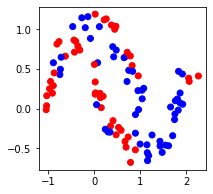

In [23]:
X_train = X_moon
Y_train = np.zeros(n_data)
# ラベルを特徴量ベクトルの|01>成分と|11>成分の和の正負によって決定
for i in range(n_data):
    Y_train[i]= np.sign(get_output_vector(X_train[i])[1].real+get_output_vector(X_train[i])[3].real)
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="bwr")
plt.show()

さて、このデータは学習できるでしょうか？以下で試します。

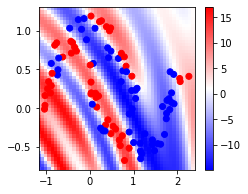

In [24]:
regularization = 100 # smaller values lead to stronger regularization
svc = SVC(C=regularization, kernel=get_gram_matrix)
svc.fit(X_train, Y_train)
n_grid = 50
x1_grid = np.linspace(np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1, n_grid)
x2_grid = np.linspace(np.min(X_train[:,1])-0.1, np.max(X_train[:,1])+0.1, n_grid)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
x1_flat = x1_grid.flatten()
x2_flat = x2_grid.flatten()
y_grid = svc.decision_function(np.array(list(zip(x1_flat, x2_flat))))
y_grid = y_grid.reshape(x1_grid.shape)
fig = plt.figure(figsize=(3.5, 3))
plt.pcolor(x1_grid, x2_grid, y_grid, cmap="bwr", shading="nearest")
plt.colorbar()
c=plt.cm.bwr(Y_train)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="bwr")
plt.show()

当然ですが、完璧に学習できていますね。量子カーネルが威力を発揮するデータセットは限られていそうです。